# A Physics-Informed Neural Network approach for compartmental epidemiological models


Notebooks for PINN solution of the SIR compartmental model presented [in the paper](https://arxiv.org/abs/2311.09944):

```
@misc{millevoi2023physicsinformed,
      title={A Physics-Informed Neural Network approach for compartmental epidemiological models}, 
      author={Caterina Millevoi and Damiano Pasetto and Massimiliano Ferronato},
      year={2023},
      eprint={2311.09944},
      archivePrefix={arXiv},
      primaryClass={math.NA}
}
```

Note: The uploaded code is related to Case 6 and Case 7. For further information please contact the corresponding author.

In [ ]:
import sciann as sn
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# Set random seed for reproducible results
sn.set_random_seed(234)

In [3]:
case = 6
# case = 7

In [4]:
df = pd.read_table("./RealData.txt")
df

,Date,I data,H data,Rt data
0,2020-02-21,216.0,123.0,2.946686
1,2020-02-22,348.0,108.0,2.828715
2,2020-02-23,462.0,151.0,2.876593
3,2020-02-24,516.0,191.0,2.908030
4,2020-02-25,1152.0,267.0,2.959534
...,...,...,...,...
85,2020-05-16,3636.0,141.0,0.670458
86,2020-05-17,1788.0,129.0,0.667726
87,2020-05-18,3930.0,180.0,0.677082
88,2020-05-19,4320.0,164.0,0.664825


In [5]:
# Time domain
timespan = df["Date"].values.astype('datetime64[D]')

t0 = 0.                 # (days) initial time
tf = len(timespan)      # (days) final time

t_data = np.arange(t0,tf)
t_test = np.arange(t0,tf,0.1)

In [6]:
# Real data
H_obs = df["H data"].values
I_obs = df["I data"].values
Rt_data = df["Rt data"].values

# parameters
delta = 1/5  # (1/T) 5 = mean reproduction period 

# Scaling factors
SI = I_obs.max()
SH = H_obs.max()

C = SI*delta/SH

I_obs_sc = I_obs/SI
H_obs_sc = H_obs/SH
t_data_sc = t_data/tf
t_test_sc = t_test/tf

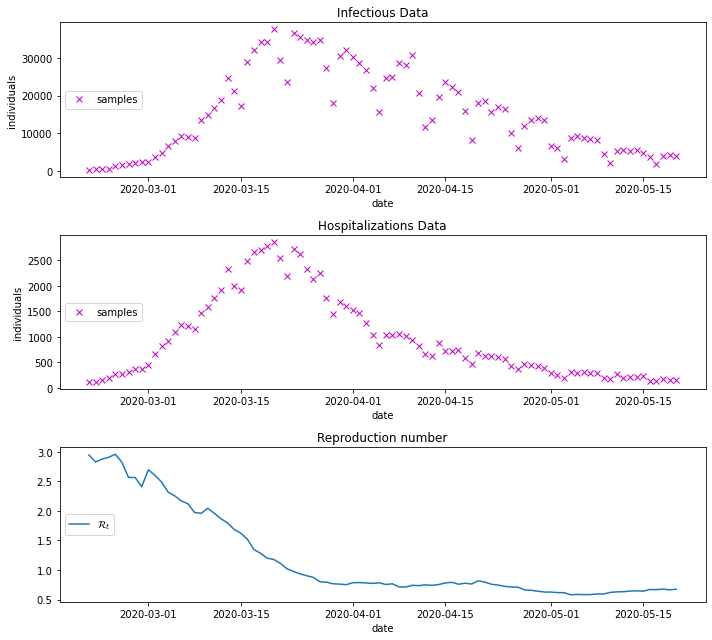

In [7]:
# Plot results
fig, ax = plt.subplots(3, 1, figsize=(10,9))

ax[0].plot(timespan, I_obs, 'xm', label='samples')
ax[0].legend(loc=6)
ax[0].set_xlabel('date')
ax[0].set_ylabel('individuals')
ax[0].set_title('Infectious Data')

ax[1].plot(timespan, H_obs, 'xm', label='samples')
ax[1].legend(loc=6)
ax[1].set_xlabel('date')
ax[1].set_ylabel('individuals')
ax[1].set_title('Hospitalizations Data')

ax[2].plot(timespan, Rt_data, label=r"$\mathcal{R}_t$")
ax[2].legend(loc=6)
ax[2].set_xlabel('date')
ax[2].set_title('Reproduction number')

fig.tight_layout()

plt.show()

In [8]:
# Training parameters
loss_err  = 'mse'
optimizer = 'adam'

### Joint

In [9]:
sn.reset_session()

In [10]:
# Build NN - Joint
ts  = sn.Variable("ts")
Is = sn.Functional("Is", ts, 4*[50], output_activation='square')
Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')

In [11]:
if case==6:
    sigma = sn.Parameter(name="sigma", inputs=ts, non_neg=True)
if case==7:
    sigma = sn.Functional("sigma", ts, 10*[5], output_activation='square')

In [12]:
# ODEs
L_dIdt = sn.rename((sn.diff(Is,ts)-tf*delta*(Rt-1)*Is), "L_dIdt")

deltaHs = sn.rename(sigma*Is*C, "deltaHs")
deltaIs = sn.rename(delta*Rt*Is, "deltaIs")

In [13]:
loss_joint = [sn.PDE(L_dIdt), sn.Data(Rt*0.0),
              sn.Data(deltaIs), sn.Data(deltaHs)]

In [14]:
m = sn.SciModel(ts, loss_joint, loss_err, optimizer)

In [15]:
# Training points
Nc = 6000    # collocation points

I_obs_sc = I_obs_sc.reshape(-1,1)
H_obs_sc = H_obs_sc.reshape(-1,1)
t_train_ode = np.random.uniform(t0/tf, 1., Nc-1)
t_train_ode = np.insert(t_train_ode,0,0.0)
t_train = np.concatenate([t_data_sc.reshape(-1,1), t_train_ode.reshape(-1,1)])
ids_data = np.arange(t_data_sc.size, dtype=np.intp)

In [16]:
loss_train   = ['zeros']*2+[(ids_data,I_obs_sc),(ids_data,H_obs_sc)]
epochs_joint = 5000
batch_size   = 100

In [ ]:
# Train the model
time1 = time.time()
h     = m.train(t_train,
                loss_train,
                epochs=epochs_joint,
                batch_size=batch_size,
                verbose=1
               )
time2 = time.time()

In [18]:
print(f'Training time: {time2-time1}')

Training time: 1676.9819633960724


Input and output dimensions need re-adjustment for post-processing.


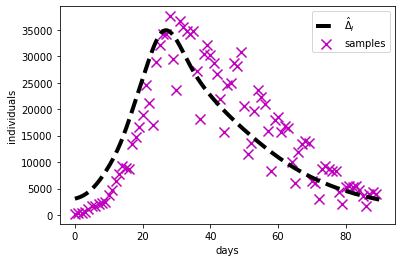

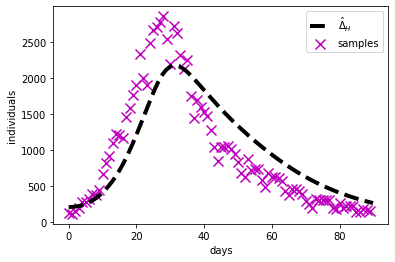

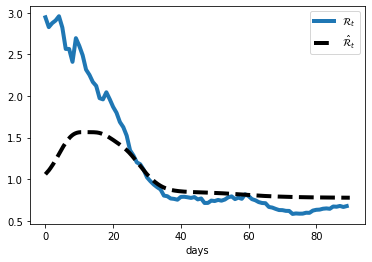

In [19]:
# Get predictions
deltaI_pred_test = deltaIs.eval(m, t_test_sc)*SI
deltaH_pred_test = deltaHs.eval(m, t_test_sc)*SH
Rt_pred_test = Rt.eval(m, t_test_sc)
sigma_pred_test = sigma.eval(m, t_test_sc)

# Plot results
plt.plot(t_test,deltaI_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\hat{\Delta}_I$','samples'])
plt.show()

# Plot results
plt.plot(t_test,deltaH_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\hat{\Delta}_H$','samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

if case==7:
    plt.plot(t_test, sigma_pred_test, '--', c='k',linewidth=4)
    plt.xlabel('days')
    plt.legend([r'$\hat{\sigma}$'])
    plt.show()

In [20]:
# Evaluate errors
Rt_pred = Rt.eval(m, t_data_sc)

Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)

print(f'Rt error: {Rt_err:.3e}')

if case==6:
    print(f'Estimated sigma: {sigma_pred_test[0]:.4f}')

Rt error: 3.912e-01
Estimated sigma: 0.0690


### Split

In [21]:
sn.reset_session()

In [22]:
# Build NN - Split - only data regression
ts  = sn.Variable("ts")
deltaHsc = sn.Functional("deltaHsc", ts, 4*[50], output_activation='square')

In [23]:
# Build the model - Split - only data regression
loss_data = sn.Data(deltaHsc)

m_data = sn.SciModel(ts, loss_data, loss_err, optimizer)

In [24]:
t_data_train = t_data_sc
epochs_data  = 1000
batch_data   = 10

In [ ]:
# Train the model - Split - only data regression
time1_data = time.time()
h_data     = m_data.train(t_data_train, 
                          H_obs_sc, 
                          epochs=epochs_data,
                          batch_size=batch_data,
                          verbose=1)
time2_data = time.time()

In [26]:
print(f'Training time: {time2_data-time1_data}')

Training time: 104.14543724060059


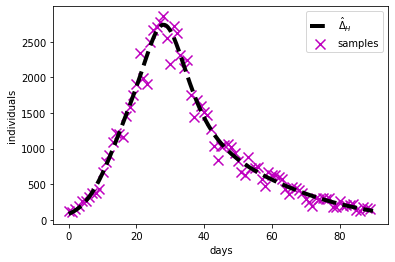

In [27]:
# Get predictions
deltaHsc_pred = deltaHsc.eval(m_data, t_test_sc)

# Plot results
plt.plot(t_test,deltaHsc_pred*SH, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend(['$\hat{\Delta}_H$','samples'])
plt.show()

In [28]:
# Fix the I-NN weights
deltaHsc_weights = deltaHsc.get_weights()

deltaHs = sn.Functional("deltaHs", ts, 4*[50], output_activation='square', trainable=False)
deltaHs.set_weights(deltaHsc_weights)

In [29]:
# Build NN - Split - fully physics-informed
Rt = sn.Functional("Rt", ts, 4*[100], output_activation='square')

if case==6:
    sigma = sn.Parameter(name="sigma", inputs=ts, non_neg=True)
if case==7:
    sigma = sn.Functional("sigma", ts, 10*[5], output_activation='square')+1e-3

In [30]:
# ODEs
Is=sn.rename(deltaHs/sigma/C, "Is")
deltaIs = sn.rename(delta*Rt*Is, "dSdt")

L_dIdt = sn.rename(sn.diff(Is,ts)-tf*delta*(Rt-1)*Is, "L_dIdt")

In [31]:
# Build the model - Split - fully physics-informed
loss_ode = [sn.PDE(L_dIdt), sn.Data(Rt*0.0),
            sn.Data(deltaIs)]

m_ode = sn.SciModel(ts, loss_ode, loss_err, optimizer)

loss_train_ode = ['zeros']*2+[(ids_data,I_obs_sc)]

epochs_ode = 3000

In [ ]:
# Train the model - Split - fully physics-informed
time1_ode = time.time()
h_ode     = m_ode.train(t_train,
                        loss_train_ode,
                        epochs=epochs_ode,
                        batch_size=batch_size,
                        verbose=1)
time2_ode = time.time()

In [33]:
print(f'Training time: {time2_ode-time1_ode}')

Training time: 1035.930900335312


Input and output dimensions need re-adjustment for post-processing.


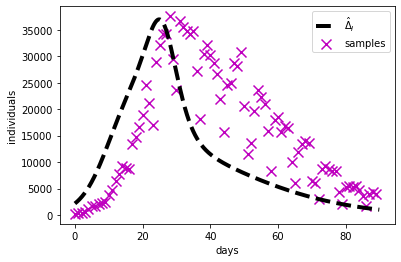

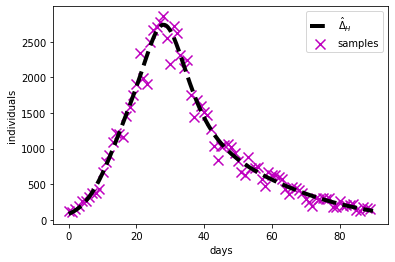

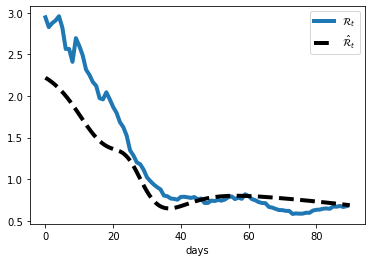

In [34]:
# Get predictions
deltaI_pred_test = deltaIs.eval(m_ode, t_test_sc)*SI
deltaH_pred_test = deltaHs.eval(m_ode, t_test_sc)*SH
Rt_pred_test = Rt.eval(m_ode, t_test_sc)
sigma_pred_test = sigma.eval(m_ode, t_test_sc)

# Plot results
plt.plot(t_test,deltaI_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,I_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\hat{\Delta}_I$','samples'])
plt.show()

# Plot results
plt.plot(t_test,deltaH_pred_test, '--', c='k', linewidth=4)
plt.scatter(t_data,H_obs, marker='x', c='m', s=100)
plt.xlabel('days')
plt.ylabel('individuals')
plt.legend([r'$\hat{\Delta}_H$','samples'])
plt.show()

plt.plot(t_data, Rt_data, linewidth=4)
plt.plot(t_test, Rt_pred_test, '--', c='k',linewidth=4)
plt.xlabel('days')
plt.legend([r'$\mathcal{R}_t$', r'$\hat{\mathcal{R}}_t$'])
plt.show()

if case==7:
    plt.plot(t_test, sigma_pred_test, '--', c='k',linewidth=4)
    plt.xlabel('days')
    plt.legend([r'$\hat{\sigma}$'])
    plt.show()

In [35]:
# Evaluate errors
Rt_pred = Rt.eval(m_ode, t_data_sc)

Rt_err = np.linalg.norm(Rt_data-Rt_pred,2)/np.linalg.norm(Rt_data,2)

print(f'Rt error: {Rt_err:.3e}')

if case==6:
    print(f'Estimated sigma: {sigma_pred_test[0]:.4f}')

Rt error: 2.464e-01
Estimated sigma: 0.0844
